In [1]:
import sys
sys.path.append('..')

In [2]:
from model_server.GTU.models.GT_UNet import *
from model_server.GTU.models.pvtv2 import pvt_v2_b2

C:\Users\DentaLink\.conda\envs\tooth\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from scipy.ndimage.morphology import distance_transform_cdt
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
import math

C:\Users\DentaLink\AppData\Local\Temp\ipykernel_10248\475188984.py:4: DeprecationWarning: Please use `distance_transform_cdt` from the `scipy.ndimage` namespace, the `scipy.ndimage.morphology` namespace is deprecated.
  from scipy.ndimage.morphology import distance_transform_cdt


In [4]:
from model_server.util import get_level_set

C:\Users\DentaLink\.conda\envs\tooth\lib\site-packages\torch\utils\_contextlib.py:125: UserWarning: Decorating classes is deprecated and will be disabled in future versions. You should only decorate functions or methods. To preserve the current behavior of class decoration, you can directly decorate the `__init__` method and nothing else.
  warnings.warn("Decorating classes is deprecated and will be disabled in "


# 1

In [5]:
_DEFAULT_SCALE_CLAMP = math.log(100000.0 / 16)

class SinusoidalPositionEmbeddings(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, time):
        device = time.device
        half_dim = self.dim // 2
        embeddings = math.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        embeddings = time[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
        return embeddings.squeeze(1)

In [46]:
class Boundary(nn.Module):
    def __init__(self, in_channel = 512):
        super().__init__()
        brige_channel = in_channel
    
        self.linear1 = nn.Sequential(
            nn.Linear(1, 256),
            nn.GELU(),
            nn.Linear(256, brige_channel//2),
            nn.GELU(),
        )
        self.linear2 = nn.Sequential(
            nn.Linear(brige_channel, brige_channel//2),
            nn.GELU(),
        )
        self.linear3 = nn.Sequential(
            nn.Linear(brige_channel//2, 1),
            nn.Sigmoid(),
        )
        self.embed = nn.Sequential(
            SinusoidalPositionEmbeddings(64),
            nn.Linear(64, brige_channel),
            nn.GELU(),
        )

        self.norm1 = nn.Sequential(
            nn.LayerNorm(brige_channel)
        )
        self.norm2 = nn.Sequential(
            nn.LayerNorm(brige_channel//2)
        )
        
    def forward(self, x, feature, t = None):# feature shape B * 1024 * 8 * 8 # 10 10
        x_skip = self.linear1(x)
        h = torch.cat([x_skip, feature], 1)
        # print(h.shape, self.embed(t).shape)
        if t is not None:
            h += self.embed(t)
            h = self.norm1(h)
        # print(self.linear2(h).shape, x_skip.shape)
        x = self.norm2(x_skip + self.linear2(h))
        x = self.linear3(x)
        return x

In [182]:
model = SinusoidalPositionEmbeddings(512)

In [186]:
a = torch.zeros((1))
model(a).shape

torch.Size([1, 512])

In [36]:
model = Boundary()

In [37]:
x = torch.ones(2, 1)
feature = torch.zeros(2,256)
time = torch.ones(2,1) * 0.5

In [38]:
model(x, feature, t = time)

tensor([[0.5878],
        [0.5878]], grad_fn=<SigmoidBackward0>)

In [234]:
torch.save(model, './edge.pkl')

# 2 

In [95]:
def extract(v, t, x_shape):
    """
    Extract some coefficients at specified timesteps, then reshape to
    [batch_size, 1, 1, 1, 1, ...] for broadcasting purposes.
    """
    device = t.device
    out = torch.gather(v, index=t, dim=0).float().to(device)
    return out.view([t.shape[0]] + [1] * (len(x_shape) - 1))

class GaussianDiffusionTrainer(nn.Module):
    def __init__(self, model, beta_1, beta_T, T):
        super().__init__()

        self.model = model
        self.T = T

        self.register_buffer(
            'betas', torch.linspace(beta_1, beta_T, T).double())
        alphas = 1. - self.betas
        alphas_bar = torch.cumprod(alphas, dim=0)

        # calculations for diffusion q(x_t | x_{t-1}) and others
        self.register_buffer(
            'sqrt_alphas_bar', torch.sqrt(alphas_bar))
        self.register_buffer(
            'sqrt_one_minus_alphas_bar', torch.sqrt(1. - alphas_bar))
        self.l1_loss = nn.L1Loss()
    def forward(self, x_0, x_feature):
        """
        Algorithm 1.
        """
        t = torch.randint(self.T, size=(x_0.shape[0], ), device=x_0.device)
        noise = torch.rand_like(x_0)
        x_t = (
            extract(self.sqrt_alphas_bar, t, x_0.shape) * x_0 +
            extract(self.sqrt_one_minus_alphas_bar, t, x_0.shape) * noise)
        # print(x_t)
        ans = self.model(x_t, x_feature, t)
        # print(ans)
        loss = self.l1_loss( ans, noise)
        return loss
    
class GaussianDiffusionSampler(nn.Module):
    def __init__(self, model, beta_1, beta_T, T):
        super().__init__()

        self.model = model
        self.T = T

        self.register_buffer('betas', torch.linspace(beta_1, beta_T, T).double())
        alphas = 1. - self.betas
        alphas_bar = torch.cumprod(alphas, dim=0)
        alphas_bar_prev = F.pad(alphas_bar, [1, 0], value=1)[:T]

        self.register_buffer('coeff1', torch.sqrt(1. / alphas))
        self.register_buffer('coeff2', self.coeff1 * (1. - alphas) / torch.sqrt(1. - alphas_bar))

        self.register_buffer('posterior_var', self.betas * (1. - alphas_bar_prev) / (1. - alphas_bar))

    def predict_xt_prev_mean_from_eps(self, x_t, t, eps):
        assert x_t.shape == eps.shape
        return (
            extract(self.coeff1, t, x_t.shape) * x_t -
            extract(self.coeff2, t, x_t.shape) * eps
        )

    def p_mean_variance(self, x_t, x_feature, t):
        # below: only log_variance is used in the KL computations
        var = torch.cat([self.posterior_var[1:2], self.betas[1:]])
        var = extract(var, t, x_t.shape)

        eps = self.model(x_t, x_feature, t)
        print("eps:", eps)
        xt_prev_mean = self.predict_xt_prev_mean_from_eps(x_t, t, eps=eps)

        return xt_prev_mean, var

    def forward(self, x_T, x_feature):
        """
        Algorithm 2.
        """
        x_t = x_T
        for time_step in reversed(range(self.T)):
            print(time_step)
            t = x_t.new_ones([x_T.shape[0], ], dtype=torch.long) * time_step
            print("t:", t)
            mean, var= self.p_mean_variance( x_t, x_feature, t=t)
            print("mean, var:", mean, var)
            # no noise when t == 0
            if time_step > 0:
                noise = torch.rand_like(x_t)
            else:
                noise = 0
            x_t = mean + torch.sqrt(var) * noise
            print(x_t)
            assert torch.isnan(x_t).int().sum() == 0, "nan in tensor."
        x_0 = x_t
        return torch.clip(x_0, -1, 1)   
    


In [51]:
x_0 = torch.zeros((12,1))
noise = torch.randn_like(x_0)

In [68]:
mi = 99999
ma = 0
for i in range(10000):
    a = torch.randn((12,1))
    if ma < a.max():
        ma = a.max()
    if mi > a.min():
        mi = a.min()
mi, ma

(tensor(-4.3489), tensor(4.2215))

## train

In [74]:
model = Boundary().cuda()
ddpmtrainer = GaussianDiffusionTrainer(model, 0, 1, 10).cuda()

In [75]:
optimizer = torch.optim.AdamW( model.parameters(), lr = 0.0001, weight_decay=1e-4)
n_epoch = 100
batch = 12
dataloader = 100

In [76]:
for epoch in range(n_epoch):
    running_loss = 0
    for data in range(dataloader):
        feature = torch.zeros((batch, 256)).cuda()
        x = torch.zeros((batch, 1)).cuda()
        optimizer.zero_grad()
        loss = ddpmtrainer( x, feature)
        print("loss:", loss)
        loss.backward()
        running_loss += loss.data.item() 
        optimizer.step()
    print("EPOCH{}/{} avg loss:{}".format( epoch, n_epoch, running_loss/dataloader))

tensor([[0.0000],
        [0.2226],
        [0.0890],
        [0.9356],
        [0.3575],
        [0.5725],
        [0.9130],
        [0.5585],
        [0.2426],
        [0.9355],
        [0.0437],
        [0.4109]], device='cuda:0')
tensor([[0.5764],
        [0.5678],
        [0.5227],
        [0.4805],
        [0.5388],
        [0.5316],
        [0.5024],
        [0.5395],
        [0.5674],
        [0.4283],
        [0.5468],
        [0.5409]], device='cuda:0', grad_fn=<SigmoidBackward0>)
loss: tensor(0.2741, device='cuda:0', grad_fn=<MeanBackward0>)
tensor([[0.0000],
        [0.1751],
        [0.4336],
        [0.2197],
        [0.5982],
        [0.8732],
        [0.6261],
        [0.7134],
        [0.8374],
        [0.8266],
        [0.3750],
        [0.5447]], device='cuda:0')
tensor([[0.6668],
        [0.6019],
        [0.6623],
        [0.6762],
        [0.6029],
        [0.5918],
        [0.6562],
        [0.6541],
        [0.5518],
        [0.6207],
        [0.6228],
        [

tensor([[0.2184],
        [0.6708],
        [0.0140],
        [0.5881],
        [0.8291],
        [0.4697],
        [0.2947],
        [0.1016],
        [0.9100],
        [0.3103],
        [0.1422],
        [0.1081]], device='cuda:0')
tensor([[0.4649],
        [0.6791],
        [0.5259],
        [0.5997],
        [0.7630],
        [0.6817],
        [0.6261],
        [0.5591],
        [0.7282],
        [0.6343],
        [0.5739],
        [0.5625]], device='cuda:0', grad_fn=<SigmoidBackward0>)
loss: tensor(0.2188, device='cuda:0', grad_fn=<MeanBackward0>)
tensor([[0.0043],
        [0.2263],
        [0.1785],
        [0.3774],
        [0.5737],
        [0.1903],
        [0.0574],
        [0.7268],
        [0.6209],
        [0.7258],
        [0.6313],
        [0.7385]], device='cuda:0')
tensor([[0.3943],
        [0.6116],
        [0.5954],
        [0.6651],
        [0.6201],
        [0.4531],
        [0.4910],
        [0.6822],
        [0.7297],
        [0.6819],
        [0.7328],
        [

tensor([[0.0780],
        [0.8467],
        [0.7604],
        [0.2182],
        [0.7507],
        [0.2199],
        [0.6809],
        [0.4460],
        [0.1217],
        [0.7844],
        [0.6882],
        [0.4460]], device='cuda:0', grad_fn=<SigmoidBackward0>)
loss: tensor(0.1080, device='cuda:0', grad_fn=<MeanBackward0>)
tensor([[0.5959],
        [0.7102],
        [0.5332],
        [0.9626],
        [0.6125],
        [0.1285],
        [0.2971],
        [0.0602],
        [0.7978],
        [0.1746],
        [0.0000],
        [0.8337]], device='cuda:0')
tensor([[0.5843],
        [0.7150],
        [0.4870],
        [0.8741],
        [0.7397],
        [0.5164],
        [0.2039],
        [0.0622],
        [0.7794],
        [0.3931],
        [0.4436],
        [0.8334]], device='cuda:0', grad_fn=<SigmoidBackward0>)
loss: tensor(0.0891, device='cuda:0', grad_fn=<MeanBackward0>)
tensor([[0.0000],
        [0.0000],
        [0.1202],
        [0.1713],
        [0.2306],
        [0.2977],
        

loss: tensor(0.0778, device='cuda:0', grad_fn=<MeanBackward0>)
tensor([[0.0675],
        [0.1067],
        [0.0820],
        [0.0000],
        [0.4121],
        [0.8613],
        [0.1119],
        [0.2120],
        [0.5411],
        [0.1333],
        [0.3701],
        [0.3886]], device='cuda:0')
tensor([[0.0823],
        [0.1043],
        [0.3717],
        [0.3733],
        [0.4164],
        [0.8932],
        [0.1065],
        [0.2011],
        [0.7630],
        [0.4444],
        [0.3629],
        [0.4085]], device='cuda:0', grad_fn=<SigmoidBackward0>)
loss: tensor(0.0412, device='cuda:0', grad_fn=<MeanBackward0>)
tensor([[0.6572],
        [0.0555],
        [0.5007],
        [0.1957],
        [0.4808],
        [0.5219],
        [0.4994],
        [0.1469],
        [0.4067],
        [0.8662],
        [0.4891],
        [0.2412]], device='cuda:0')
tensor([[0.7963],
        [0.0847],
        [0.5719],
        [0.2314],
        [0.5630],
        [0.5909],
        [0.7894],
        [0.1294],


loss: tensor(0.0515, device='cuda:0', grad_fn=<MeanBackward0>)
tensor([[0.3824],
        [0.7839],
        [0.2534],
        [0.7860],
        [0.1754],
        [0.0000],
        [0.2452],
        [0.0000],
        [0.6738],
        [0.0000],
        [0.6339],
        [0.8759]], device='cuda:0')
tensor([[0.3599],
        [0.7782],
        [0.2168],
        [0.8050],
        [0.1892],
        [0.4238],
        [0.3189],
        [0.4238],
        [0.8059],
        [0.4238],
        [0.8324],
        [0.8734]], device='cuda:0', grad_fn=<SigmoidBackward0>)
loss: tensor(0.0544, device='cuda:0', grad_fn=<MeanBackward0>)
tensor([[0.3082],
        [0.1821],
        [0.5303],
        [0.5538],
        [0.7577],
        [0.4735],
        [0.0000],
        [0.0794],
        [0.1115],
        [0.0000],
        [0.0000],
        [0.0000]], device='cuda:0')
tensor([[0.7158],
        [0.5534],
        [0.5336],
        [0.5787],
        [0.7623],
        [0.4790],
        [0.4418],
        [0.1163],


loss: tensor(0.0319, device='cuda:0', grad_fn=<MeanBackward0>)
tensor([[0.5513],
        [0.0000],
        [0.0279],
        [0.2046],
        [0.4848],
        [0.5335],
        [0.0710],
        [0.7918],
        [0.5120],
        [0.3729],
        [0.5495],
        [0.2621]], device='cuda:0')
tensor([[0.6870],
        [0.4630],
        [0.0791],
        [0.1862],
        [0.6832],
        [0.5714],
        [0.0982],
        [0.8785],
        [0.5295],
        [0.6555],
        [0.6849],
        [0.6734]], device='cuda:0', grad_fn=<SigmoidBackward0>)
loss: tensor(0.0450, device='cuda:0', grad_fn=<MeanBackward0>)
tensor([[0.3139],
        [0.0217],
        [0.1989],
        [0.4556],
        [0.6279],
        [0.1202],
        [0.3278],
        [0.9715],
        [0.4879],
        [0.5320],
        [0.1852],
        [0.0097]], device='cuda:0')
tensor([[0.7396],
        [0.0951],
        [0.2230],
        [0.5052],
        [0.7216],
        [0.1314],
        [0.3128],
        [0.9027],


tensor([[0.6795],
        [0.5725],
        [0.3896],
        [0.0829],
        [0.5279],
        [0.0841],
        [0.2829],
        [0.8608],
        [0.0707],
        [0.1334],
        [0.3713],
        [0.8772]], device='cuda:0')
tensor([[0.7174],
        [0.6167],
        [0.5814],
        [0.1124],
        [0.8749],
        [0.1014],
        [0.3068],
        [0.9160],
        [0.1031],
        [0.2582],
        [0.4439],
        [0.8869]], device='cuda:0', grad_fn=<SigmoidBackward0>)
loss: tensor(0.0373, device='cuda:0', grad_fn=<MeanBackward0>)
tensor([[0.0000],
        [0.4049],
        [0.4607],
        [0.0000],
        [0.8069],
        [0.1146],
        [0.0220],
        [0.0897],
        [0.1772],
        [0.1310],
        [0.0284],
        [0.5134]], device='cuda:0')
tensor([[0.4113],
        [0.7458],
        [0.8126],
        [0.4113],
        [0.8217],
        [0.4295],
        [0.0840],
        [0.1161],
        [0.5476],
        [0.1366],
        [0.0871],
        [

tensor([[0.2577],
        [0.2118],
        [0.1174],
        [0.4181],
        [0.3801],
        [0.0000],
        [0.2592],
        [0.2168],
        [0.8579],
        [0.4030],
        [0.0000],
        [0.5630]], device='cuda:0')
tensor([[0.2367],
        [0.6747],
        [0.1494],
        [0.4027],
        [0.3543],
        [0.4751],
        [0.2233],
        [0.2142],
        [0.9092],
        [0.4954],
        [0.4751],
        [0.6024]], device='cuda:0', grad_fn=<SigmoidBackward0>)
loss: tensor(0.0925, device='cuda:0', grad_fn=<MeanBackward0>)
tensor([[0.8069],
        [0.0000],
        [0.4860],
        [0.4663],
        [0.5004],
        [0.8032],
        [0.5407],
        [0.9404],
        [0.4190],
        [0.3641],
        [0.4864],
        [0.3293]], device='cuda:0')
tensor([[0.8396],
        [0.4471],
        [0.7137],
        [0.5705],
        [0.5122],
        [0.8837],
        [0.6726],
        [0.8874],
        [0.4186],
        [0.3543],
        [0.5996],
        [

tensor([[0.1955],
        [0.8094],
        [0.6387],
        [0.3344],
        [0.1474],
        [0.3981],
        [0.3032],
        [0.2946],
        [0.0491],
        [0.2630],
        [0.0000],
        [0.2489]], device='cuda:0')
tensor([[0.2750],
        [0.8555],
        [0.8718],
        [0.3533],
        [0.3335],
        [0.5074],
        [0.3342],
        [0.6251],
        [0.1259],
        [0.2941],
        [0.5709],
        [0.2701]], device='cuda:0', grad_fn=<SigmoidBackward0>)
loss: tensor(0.0653, device='cuda:0', grad_fn=<MeanBackward0>)
tensor([[0.6225],
        [0.2557],
        [0.3055],
        [0.0672],
        [0.5213],
        [0.8661],
        [0.0530],
        [0.4198],
        [0.5997],
        [0.9204],
        [0.2937],
        [0.2235]], device='cuda:0')
tensor([[0.7791],
        [0.2671],
        [0.2955],
        [0.1455],
        [0.8921],
        [0.8557],
        [0.1385],
        [0.8099],
        [0.6414],
        [0.8696],
        [0.8272],
        [

tensor([[0.2886],
        [0.1764],
        [0.6754],
        [0.4915],
        [0.0000],
        [0.9860],
        [0.8585],
        [0.6115],
        [0.7583],
        [0.4220],
        [0.2085],
        [0.7257]], device='cuda:0')
tensor([[0.2820],
        [0.1672],
        [0.8209],
        [0.5160],
        [0.4595],
        [0.9144],
        [0.9168],
        [0.6689],
        [0.8067],
        [0.4282],
        [0.1916],
        [0.8000]], device='cuda:0', grad_fn=<SigmoidBackward0>)
loss: tensor(0.0416, device='cuda:0', grad_fn=<MeanBackward0>)
tensor([[0.7325],
        [0.0825],
        [0.9575],
        [0.1170],
        [0.8482],
        [0.2943],
        [0.2340],
        [0.8514],
        [0.5407],
        [0.4089],
        [0.0000],
        [0.7062]], device='cuda:0')
tensor([[0.8106],
        [0.3888],
        [0.9069],
        [0.4690],
        [0.8826],
        [0.2894],
        [0.2218],
        [0.9171],
        [0.6217],
        [0.7878],
        [0.4983],
        [

tensor([[0.5583],
        [0.4145],
        [0.8961],
        [0.1407],
        [0.8245],
        [0.3297],
        [0.6939],
        [0.0171],
        [0.6315],
        [0.3618],
        [0.8035],
        [0.9819]], device='cuda:0')
tensor([[0.6713],
        [0.6272],
        [0.8728],
        [0.1790],
        [0.8426],
        [0.8574],
        [0.7976],
        [0.2428],
        [0.7458],
        [0.3934],
        [0.8264],
        [0.9034]], device='cuda:0', grad_fn=<SigmoidBackward0>)
loss: tensor(0.0680, device='cuda:0', grad_fn=<MeanBackward0>)
tensor([[0.0000],
        [0.8474],
        [0.7401],
        [0.8303],
        [0.1440],
        [0.1239],
        [0.1968],
        [0.8990],
        [0.0737],
        [0.5056],
        [0.3706],
        [0.6965]], device='cuda:0')
tensor([[0.5248],
        [0.9127],
        [0.8678],
        [0.9070],
        [0.5300],
        [0.1729],
        [0.3446],
        [0.8849],
        [0.1359],
        [0.6589],
        [0.4670],
        [

tensor([[0.3542],
        [0.0850],
        [0.6611],
        [0.9515],
        [0.0000],
        [0.4210],
        [0.8431],
        [0.2911],
        [0.0891],
        [0.7786],
        [0.0000],
        [0.7289]], device='cuda:0')
tensor([[0.5960],
        [0.1362],
        [0.8465],
        [0.8846],
        [0.3716],
        [0.4195],
        [0.8812],
        [0.4571],
        [0.1263],
        [0.7841],
        [0.3716],
        [0.7653]], device='cuda:0', grad_fn=<SigmoidBackward0>)
loss: tensor(0.0684, device='cuda:0', grad_fn=<MeanBackward0>)
tensor([[0.3040],
        [0.1092],
        [0.1291],
        [0.7948],
        [0.8321],
        [0.2846],
        [0.5632],
        [0.7613],
        [0.5992],
        [0.0884],
        [0.7479],
        [0.0000]], device='cuda:0')
tensor([[0.3599],
        [0.1429],
        [0.1546],
        [0.7955],
        [0.8196],
        [0.2695],
        [0.5980],
        [0.7728],
        [0.6995],
        [0.1246],
        [0.7608],
        [

KeyboardInterrupt: 

## test

In [96]:
model = Boundary().cuda()
ddpmsampler = GaussianDiffusionSampler(model, 0, 1, 10).cuda()

In [100]:
ddpmsampler.coeff1, ddpmsampler.coeff2

(tensor([1.0000, 1.0607, 1.1339, 1.2247, 1.3416, 1.5000, 1.7321, 2.1213, 3.0000,
            inf], device='cuda:0', dtype=torch.float64),
 tensor([   nan, 0.3536, 0.4536, 0.5560, 0.6913, 0.8852, 1.1772, 1.6569, 2.6679,
            inf], device='cuda:0', dtype=torch.float64))

In [101]:
1. - ddpmsampler.betas

tensor([1.0000, 0.8889, 0.7778, 0.6667, 0.5556, 0.4444, 0.3333, 0.2222, 0.1111,
        0.0000], device='cuda:0', dtype=torch.float64)

In [97]:
with torch.no_grad():
    model.eval()

    noiseidx = torch.rand((1, 1)).cuda()
    feature_sample = torch.randn((1,256)).cuda()
    sampledImgs = ddpmsampler(noiseidx, feature_sample)
    print(sampledImgs)

9
t: tensor([9], device='cuda:0')
eps: tensor([[0.4265]], device='cuda:0')
mean, var: tensor([[nan]], device='cuda:0') tensor([[1.]], device='cuda:0')
tensor([[nan]], device='cuda:0')


AssertionError: nan in tensor.

# 3

In [4]:
class GT_U_DC_PVTNet(nn.Module):
    def __init__(self, img_ch  =  1, output_ch  =  1, 
                middle_channel = [64, 128, 256, 512, 1024], 
                encode_len = 5, 
                need_return_dict = True,
                need_supervision = False,
                decode_type = "conv",
                path = '../model/GTU/models/pretrained_pth/pvt_v2_b2.pth'

        ):
        super(GT_U_DC_PVTNet, self).__init__()
        pvt_channel = [64, 128, 320, 512]
        self.index_len = encode_len - 1
        self.need_return_dict = need_return_dict
        self.downsample = nn.AvgPool2d(2)
        self.Maxpool  =  nn.MaxPool2d(kernel_size = 2,stride = 2)
        self.erode = MinPool(2,2,1)
        self.dilate = nn.MaxPool2d(2, stride = 1)
        self.encode_list = nn.ModuleList()
        self.up_list = nn.ModuleList()
        self.decode_list = nn.ModuleList()
        self.sk_list = nn.ModuleList()
        if self.need_return_dict:
            self.supervision_list = nn.ModuleList()
        # self.select  =  nn.Conv2d( 2, output_ch, kernel_size = 1, stride = 1, padding = 0)
        middle_channel = middle_channel[ len(middle_channel) - encode_len : ]
        middle_channel =  [ img_ch, *middle_channel]
        self.need_supervision = need_supervision
        print( middle_channel )
        self.pre_encode = ResGroupFormer(middle_channel[0], middle_channel[ 1 ]) 
        # self.pre_encode = _make_bot_layer(
        #     ch_in = middle_channel[0],         
        #     ch_out = middle_channel[ 1 ], 
        #     w = 4
        # )
        for i in range(1, encode_len):
            self.encode_list.append( 
                ResGroupFormer( ch_in = 2 * middle_channel[i],             
                    ch_out = middle_channel[ i+1 ],  )
                # nn.Sequential(
                # _make_bot_layer(
                #     ch_in = 2 * middle_channel[i],             
                #     ch_out = middle_channel[ i+1 ], 
                #     w = 4
                # ) ,
                # _make_bot_layer(
                #     ch_in = middle_channel[ i+1 ],             
                #     ch_out = middle_channel[ i+1 ], 
                #     w = 4
                # ) ,
                # _make_bot_layer(
                #     ch_in = middle_channel[ i+1 ],             
                #     ch_out = middle_channel[ i+1 ], 
                #     w = 4
                # ) ,
                # )
            )
        
        for i in range(1, encode_len):
            now_dim = encode_len - i + 1
            next_dim = encode_len - i
            # print( middle_channel[ now_dim ],   middle_channel[ next_dim ])
            self.up_list.append( 
                up_conv(ch_in = middle_channel[now_dim ] , ch_out = 2 * middle_channel[next_dim]) 
            )
          
            if i < self.index_len :
                # print(pvt_channel[ 4 - i - 1 ], middle_channel[now_dim ])
                self.sk_list.append( 
                    SKConv([pvt_channel[ self.index_len - i - 1], middle_channel[now_dim ]], middle_channel[now_dim ], 32,2,8,2)
                )
                
          
            self.decode_list.append( 
                    Decode(ch_in = 2 * middle_channel[ now_dim ], ch_out = middle_channel[next_dim], decode_type =  decode_type) 
                    # SKConv([middle_channel[ now_dim ], middle_channel[now_dim ]], middle_channel[next_dim], 32,2,8,2)
                )
            
            print("sk:",len(self.sk_list))
            if self.need_supervision:
                self.supervision_list.append( nn.Conv2d(middle_channel[next_dim], output_ch, 1, 1) )
            #  _make_bot_layer(
            #     ch_in = 2 * middle_channel[ now_dim ], 
            #     ch_out = middle_channel[next_dim],
            #     w = 2 ** i) 
            #  )
            
        self.CBR = nn.ModuleList()
        for i in range(encode_len):
            self.CBR.append(
                nn.Sequential(
                    nn.Conv2d(middle_channel[0], middle_channel[i+1], 3, 1, 1),
                    nn.BatchNorm2d(middle_channel[i+1]),
                    nn.ReLU(),
                )
            )
        self.last_up = nn.Upsample(scale_factor = 2)
        self.last_decode = nn.Conv2d(middle_channel[next_dim], output_ch, kernel_size = 1, stride = 1, padding = 0)
        if self.need_supervision:
            self.supervision_list.append( nn.Conv2d(middle_channel[next_dim], output_ch, 1, 1) )

        self.select = nn.Sequential(
                nn.Conv2d(2, 32, 3, 1, 1),
                nn.BatchNorm2d(32),
                nn.ReLU(),
                nn.Conv2d( 32, 16, 3, 1, 1),
                nn.BatchNorm2d(16),
                nn.ReLU(),
                nn.Conv2d( 16, 1, 1, 1),
                nn.BatchNorm2d(1),
                nn.ReLU(),
            )
        # self.edge_hot = nn.Sequential(
            
        # )

        self.backbone = pvt_v2_b2()  # [64, 128, 320, 512]
        
#         save_model = torch.load(path)
#         model_dict = self.backbone.state_dict()
#         state_dict = {k: v for k, v in save_model.items() if k in model_dict.keys()}
#         model_dict.update(state_dict)
#         self.backbone.load_state_dict(model_dict)
        n_p = sum(x.numel() for x in self.backbone.parameters()) # number parameters
        n_g = sum(x.numel() for x in self.backbone.parameters() if x.requires_grad)  # number gradients
        print(f"pvt Summary: {len(list(self.backbone.modules()))} layers, {n_p} parameters, {n_p/1e6} M, {n_g} gradients")

    def build_results(self, x,y,z, super_vision  = None):
        if super_vision is None:
            return {
            "mask": x,
            "levelset": y,
            "edge":z,
        }
        else:
            return {
                "mask": x,
                "levelset": y,
                "edge":z,
                "super":super_vision
            }
            
    def build_feature_pyramid(self, x): # 80
        x_list = []
        for i in range(self.index_len + 1):
            x = self.downsample(x) 
            x_list.append( x )
        return   x_list
    
    def edge_hot_map(self, x1):
        x = x1.clone().detach()
        x[x < 0.5] = 0
        x[x >= 0.5] = 1
        edge = nn.functional.pad(x, (1, 0, 1, 0))
        edge = self.dilate(edge) - self.erode(edge)
        # edge = self.edge_hot(edge)
        return edge
    
    def level_set_map(self, x):
        level_set = get_level_set(x)
        
        return edge
    
    def pvt_backbone(self, x):
        x = x.clone().detach()
        pvt_x = torch.cat([x,x,x], 1)
        pvt = self.backbone(pvt_x)
        return pvt
    
    def forward(self,x):
        pvt = self.pvt_backbone(x)
        c1, c2, c3, c4 = pvt
        # pvt_decode = [c3, c2, c1]
        pvt_decode = list( reversed( pvt[:len(self.sk_list)] ) )
        
        x_list = self.build_feature_pyramid( x )
        pre_x_list = []
        out_list = []
        supervision = []
        for index in range(len(x_list)):
            pre_x = self.CBR[index](x_list[index])
            pre_x_list.append(pre_x)
            # print(x_list[index].shape, pre_x.shape)
        # pre_x_list = [x, *pre_x_list]
       
        out = self.pre_encode( x )
        out_pool = self.Maxpool(out)
        out_list.append(out)
        # print( "x{}:{} {}".format( 0, out.shape, out_pool.shape ))
        
        # encoding
        for index in range(self.index_len):
            x_temp = torch.cat( [pre_x_list[index], out_pool], 1) 
            print( "x{} cat:{}".format( index, x.shape))
            out = self.encode_list[index]( x_temp )
            out_pool = self.Maxpool(out)
            out_list.append(out)
            
            # print( "x{}:{} {}".format( index + 1, out.shape, out_pool.shape ))
            
        x_temp = out_pool 
        # decoding
        for index in range(len(self.sk_list)):
            up = out_list[ self.index_len - index ]
            # print(up.shape, pvt_decode[index].shape)
            conmbine_feature = self.sk_list[index](( pvt_decode[index] , up))
            out_list[ self.index_len - index] = conmbine_feature
            print("index:", index, self.index_len - index, "pvt and up", pvt_decode[index].shape, up.shape)
        
            
        for index in range(self.index_len):
            # up = self.up_list[index](x_temp)
            # x_temp = torch.cat( [up, out_list[ self.index_len - index ] ], dim = 1)
            up = out_list[ self.index_len - index ]
           
            print("decode (up, x_temp):", up.shape, x_temp.shape)
            x_temp = self.decode_list[index](up, x_temp)
            
            
            # x_temp = self.decode_list[index](x_temp)
            supervision.append(x_temp)
            # self.need_supervision[index](x_temp)
            # print( "decode{}:{} {}".format( index, up.shape, x_temp.shape))
        
        # print("final decode:", x_temp.shape)
        outp = self.last_up(x_temp)
        out = self.last_decode(outp)
        
        if self.need_return_dict == False:
            return out, outp
        
        edge = self.edge_hot_map(out)
        outp = self.select(torch.cat([out, edge], 1))


        # print("outp:{}".format( outp.shape ))
        if self.need_supervision:
            for i in range( self.index_len ):
                supervision[i] = self.supervision_list[i](supervision[i])
            return self.build_results(outp, outp, edge, supervision) if self.need_return_dict else( outp, edge, supervision) 
        return self.build_results(outp, out, edge) if self.need_return_dict else( outp, edge ) 


In [5]:
model = GT_U_DC_PVTNet()

[1, 64, 128, 256, 512, 1024]
detype conv
sk: 1
detype conv
sk: 2
detype conv
sk: 3
detype conv
sk: 3
pvt Summary: 319 layers, 24849856 parameters, 24.849856 M, 24849856 gradients


In [6]:
a = torch.zeros((2,1,256,256))

32.0

In [13]:
with torch.no_grad():
    ans = model(a)

x0 cat:torch.Size([2, 1, 256, 256])
x1 cat:torch.Size([2, 1, 256, 256])
x2 cat:torch.Size([2, 1, 256, 256])
x3 cat:torch.Size([2, 1, 256, 256])
index: 0 4 pvt and up torch.Size([2, 320, 16, 16]) torch.Size([2, 1024, 16, 16])
index: 1 3 pvt and up torch.Size([2, 128, 32, 32]) torch.Size([2, 512, 32, 32])
index: 2 2 pvt and up torch.Size([2, 64, 64, 64]) torch.Size([2, 256, 64, 64])
decode (up, x_temp): torch.Size([2, 1024, 16, 16]) torch.Size([2, 1024, 8, 8])
decode (up, x_temp): torch.Size([2, 512, 32, 32]) torch.Size([2, 512, 16, 16])
decode (up, x_temp): torch.Size([2, 256, 64, 64]) torch.Size([2, 256, 32, 32])
decode (up, x_temp): torch.Size([2, 128, 128, 128]) torch.Size([2, 128, 64, 64])


AttributeError: 'dict' object has no attribute 'shape'

In [16]:
ans['mask'].shape, ans['edge'].shape, 

(torch.Size([2, 1, 256, 256]), torch.Size([2, 1, 256, 256]))

In [169]:
import numpy as np
import copy
import cv2

class MinPool(nn.Module):
    def __init__(self, kernel_size, ndim=2, stride=None, padding=0, dilation=1, return_indices=False, ceil_mode=False):
        super(MinPool, self).__init__()
        self.pool = getattr(nn, f'MaxPool{ndim}d')(kernel_size=kernel_size, stride=stride, padding=padding, dilation=dilation,
                                                  return_indices=return_indices, ceil_mode=ceil_mode)
    @torch.no_grad()
    def forward(self, x):
        x = self.pool(-x)
        return -x

def get_2D_over_mask(x, dilate_num = 2, iter_num = 6, kernel = np.ones((3, 3), np.uint8)):
    
    img_dilate = x
    for i in range(iter_num):
        img_dilate = cv2.dilate(img_dilate, kernel, iterations = dilate_num)

    depth_i = distance_transform_cdt(img_dilate, metric='taxicab')
    return depth_i


ERODE = MinPool(3,2,1).cuda()
DILATE = nn.MaxPool2d(3, stride = 1).cuda()

def Dilate(x, kernel = DILATE, number_iter = 4):
    for i in range(number_iter):
        x = nn.functional.pad(x, (1, 1, 1, 1))
        x = kernel(x)
    return x

def get_dis_map(x, kernel = ERODE):
    dis_map = torch.zeros_like(x)
    while torch.sum(x):
        dis_map += x
        x = nn.functional.pad(x, (1, 1, 1, 1))
        x = kernel(x)
    return dis_map

def get_Level_set( x ):
    x = Dilate(x)
    return get_dis_map(x)


In [170]:
a1 = torch.zeros((2,1,256,256)).cuda()
a1[:,:, 64:192, 64:192] = 1

In [171]:
ans = get_Level_set(a1)

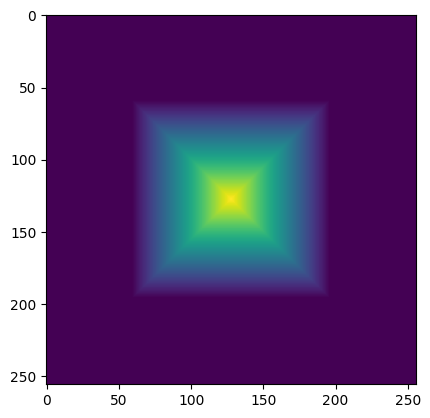

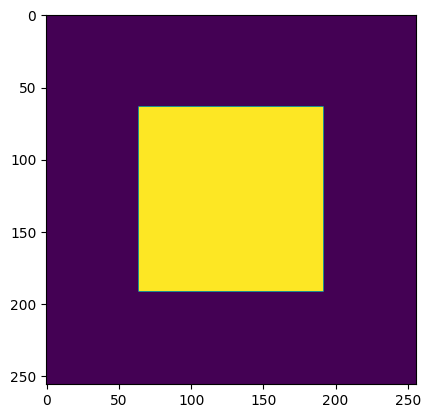

In [172]:
plt.imshow(ans[0].cpu().squeeze())
plt.show()
plt.imshow(a1[0].cpu().squeeze())
plt.show()